In [ ]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Validation Sets and Test Sets

The previous Colab exercises evaluated the trained model against the training set, which does not provide a strong signal about the quality of your model. In this Colab, you'll experiment with validation sets and test sets.






## Learning objectives

After doing this Colab, you'll know how to do the following:

  * Split a [training set](https://developers.google.com/machine-learning/glossary/#training_set) into a smaller training set and a [validation set](https://developers.google.com/machine-learning/glossary/#validation_set).
  * Analyze deltas between training set and validation set results.
  * Test the trained model with a [test set](https://developers.google.com/machine-learning/glossary/#test_set) to determine whether your trained model is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting).
  * Detect and fix a common training problem.

## The dataset

As in the previous exercise, this exercise uses the [California Housing dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) to predict the `median_house_value` at the city block level.  Like many "famous" datasets, the California Housing Dataset actually consists of two separate datasets, each living in separate .csv files:

* The training set is in `california_housing_train.csv`.
* The test set is in `california_housing_test.csv`.

You'll create the validation set by dividing the downloaded training set into two parts:

* a smaller training set  
* a validation set

## Import relevant modules

This first code cell imports the necessary modules and sets a few display options.

In [1]:
#@title Import modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10 # 設置顯示的最大行數為 10 行。
pd.options.display.float_format = "{:.1f}".format # 設置浮點數顯示格式為 1 位小數。

## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set.
* `test_df`, which contains the test set.



In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Scale the label values

The following code cell scales the `median_house_value`.
See the previous Colab exercise for details.

縮放數據的目的是為了讓數據處於一個相對較小且均勻的範圍內，這樣有助於提高機器學習模型的性能，尤其是在梯度下降等優化過程中，避免數值過大或過小導致的計算問題。縮放可以使模型更快地收斂到最佳解並提高預測精度。

In [3]:
scale_factor = 1000.0

# Scale the training set's label.
train_df["median_house_value"] /= scale_factor

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

In [4]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111.4
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103.6
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85.8


## Load the functions that build and train a model

The following code cell defines two functions:

  * `build_model`, which defines the model's topography.
  * `train_model`, which will ultimately train the model, outputting not only the loss value for the training set but also the loss value for the validation set.

Since you don't need to understand model building code right now, we've hidden this code cell. As always, you must run hidden code cells.

In [8]:
#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  # 使用 tf.keras.models.Sequential() 構建一個順序模型。
  model = tf.keras.models.Sequential()

  # Add one linear layer to the model to yield a simple linear regressor.
  # 向模型中添加一個線性層(Dense 層)，該層包含一個單元(units=1)，輸入形狀為一維(input_shape=(1,))。
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  # 編譯模型時，使用 RMSprop 優化器並設定學習率，
  # 損失函數為均方誤差（mean_squared_error），評估指標為根均方誤差（RootMeanSquaredError）。
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

# 接收多個參數：模型 model、數據框 df、特徵列 feature、標籤列 label、訓練輪數
# my_epochs、批次大小 my_batch_size（默認為 None）和驗證集比例 my_validation_split（默認為 0.1）。
def train_model(model, df, feature, label, my_epochs,
                my_batch_size=None, my_validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # model.fit() 方法將數據集輸入到模型中進行訓練。設置特徵列和標籤列、批次大小、訓練輪數和驗證集比例。
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=my_batch_size,
                      epochs=my_epochs,
                      validation_split=my_validation_split)

  # Gather the model's trained weight and bias.
  # 從模型中提取訓練好的權重和偏差。
  trained_weight = model.get_weights()[0][0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  # 提取歷史數據中的訓練輪數（epochs）。
  epochs = history.epoch

  # Isolate the root mean squared error for each epoch.
  # 將歷史數據轉換為 DataFrame
  hist = pd.DataFrame(history.history)
  # 提取歷史數據中每一輪的根均方誤差（rmse）。
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history

print("Defined the build_model and train_model functions.")

Defined the build_model and train_model functions.


## Define plotting functions

The `plot_the_loss_curve` function plots loss vs. epochs for both the training set and the validation set.

函數繪製訓練和驗證損失隨訓練輪數（epochs）變化的曲線。這可以幫助我們視覺化模型在訓練過程中的表現。

In [6]:
#@title Define the plotting function

# 輸入參數：epochs：訓練輪數列表。
# mae_training：每一輪的訓練集均方誤差（RMSE）。
# mae_validation：每一輪的驗證集均方誤差（RMSE）。
def plot_the_loss_curve(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  # 繪製損失曲線：
  # 這裡跳過了第一個 epoch 的數據，因為第一個 epoch 的損失通常會顯著大於其他 epoch。
  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()

  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  print('mae_training:', mae_training[1:])
  print('mae_validation:', mae_validation[1:])

  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  print(highest_loss, lowest_loss)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)

  # 設置 Y 軸範圍，使曲線圖在視覺上更具可讀性。
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


## Task 1: Experiment with the validation split

In the following code cell, you'll see a variable named `validation_split`, which we've initialized at 0.2.  The `validation_split` variable specifies the proportion of the original training set that will serve as the validation set. The original training set contains 17,000 examples. Therefore, a `validation_split` of 0.2 means that:

* 17,000 * 0.2 ~= 3,400 examples will become the validation set.
* 17,000 * 0.8 ~= 13,600 examples will become the new training set.

The following code builds a model, trains it on the training set, and evaluates the built model on both:

* The training set.
* And the validation set.

If the data in the training set is similar to the data in the validation set, then the two loss curves and the final loss values should be almost identical. However, the loss curves and final loss values are **not** almost identical. Hmm, that's odd.  

Experiment with two or three different values of `validation_split`.  Do different values of `validation_split` fix the problem?


Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 44531.3086 - root_mean_squared_error: 210.7909 - val_loss: 46716.9844 - val_root_mean_squared_error: 216.1411
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 25141.4805 - root_mean_squared_error: 158.4560 - val_loss: 27131.8770 - val_root_mean_squared_error: 164.7176
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13564.7910 - root_mean_squared_error: 116.3431 - val_loss: 14684.4404 - val_root_mean_squared_error: 121.1794
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7834.5884 - root_mean_squared_error: 88.4589 - val_loss: 9533.8096 - val_root_mean_squared_error: 97.6412
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6545.2402 - root_mean_squared_error: 80.8978 - val_loss: 9200.4697 - val_root_mean_squared_error: 95.9191
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6582.1572 - root_mean_squared_error: 81.1182 - val_loss: 9236.1221 - val_root_mean_squared_error: 

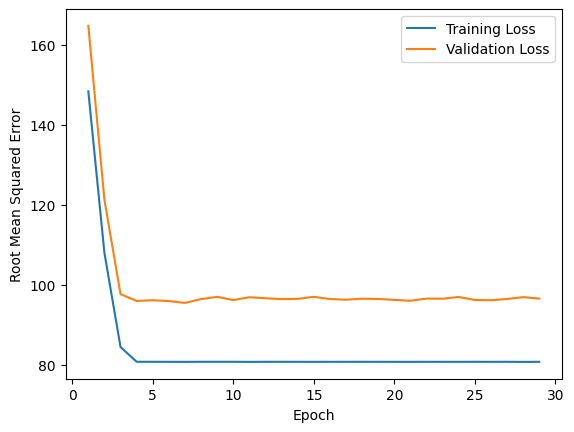

In [9]:
# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 30
batch_size = 100

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

# Identify the feature and the label.
my_feature = "median_income"    # the median income on a specific city block.
my_label = "median_house_value" # the median house value on a specific city block.
# That is, you're going to create a model that predicts house value based
# solely on the neighborhood's median income.

# Invoke the functions to build and train the model.
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, train_df, my_feature,
                                    my_label, epochs, batch_size,
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"],
                    history["val_root_mean_squared_error"])

## Task 2: Determine **why** the loss curves differ

No matter how you split the training set and the validation set, the loss curves differ significantly. Evidently, the data in the training set isn't similar enough to the data in the validation set. Counterintuitive? Yes, but this problem is actually pretty common in machine learning.

Your task is to determine **why** the loss curves aren't highly similar. As with most issues in machine learning, the problem is rooted in the data itself. To solve this mystery of why the training set and validation set aren't almost identical, write a line or two of [pandas code](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=validation-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en) in the following code cell.  Here are a couple of hints:

  * The previous code cell split the original training set into:
    * a reduced training set (the original training set - the validation set)
    * the validation set
  * By default, the pandas [`head`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method outputs the *first* 5 rows of the DataFrame. To see more of the training set, specify the `n` argument to `head` and assign a large positive integer to `n`.

In [11]:
# Examine examples 0 through 4 and examples 995 through 999
# of the training set
train_df.head(n=1000)

# The original training set is sorted by longitude.
# Apparently, longitude influences the relationship of
# median_income to median_house_value.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5
...,...,...,...,...,...,...,...,...,...
995,-117.1,32.5,8.0,6533.0,1217.0,4797.0,1177.0,4.0,144.4
996,-117.1,34.6,6.0,5110.0,1044.0,1938.0,724.0,3.2,112.8
997,-117.1,34.2,22.0,4397.0,931.0,1145.0,445.0,4.5,108.4
998,-117.1,34.0,24.0,4144.0,826.0,2127.0,772.0,2.5,96.0


## Task 3. Fix the problem

To fix the problem, shuffle the examples in the training set before splitting the examples into a training set and validation set. To do so, take the following steps:

1. Shuffle the data in the training set by adding the following line anywhere before you call `train_model` (in the code cell associated with Task 1):  
打亂訓練數據集 train_df 的順序。
* 防止順序依賴
* 提高模型的泛化能力


```
  shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
  /*
  np.random.permutation(train_df.index)：生成隨機排列的數據索引。
  train_df.reindex(...)：根據隨機排列的索引重新排列數據集。
  */
```                                    

2. Pass `shuffled_train_df` (instead of `train_df`) as the second argument to `train_model` (in the code call associated with Task 1) so that the call becomes as follows:

```
  epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature,
                                      my_label, epochs, batch_size,
                                      validation_split)
```

Epoch 1/70


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 46316.9805 - root_mean_squared_error: 215.0916 - val_loss: 32234.7715 - val_root_mean_squared_error: 179.5405
Epoch 2/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27185.6777 - root_mean_squared_error: 164.7547 - val_loss: 17959.3555 - val_root_mean_squared_error: 134.0125
Epoch 3/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15104.7734 - root_mean_squared_error: 122.7207 - val_loss: 9850.2910 - val_root_mean_squared_error: 99.2486
Epoch 4/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8269.4834 - root_mean_squared_error: 90.8750 - val_loss: 7458.9019 - val_root_mean_squared_error: 86.3649
Epoch 5/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6852.2861 - root_mean_squared_error: 82.7754 - val_loss: 7430.2568 - val_root_mean_squared_error: 86.1989
Epoch 6/70
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6920.1152 - root_mean_squared_error: 83.1779 - val_loss: 7434.6167 - val_root_mean_squared_error: 86.2242
Epoch

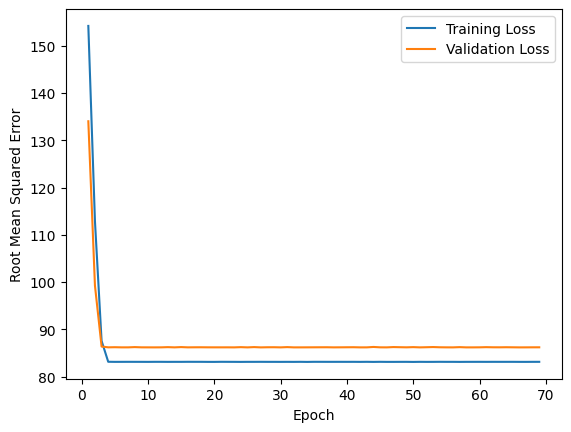

In [12]:
#@title Double-click to view the complete implementation.

# The following variables are the hyperparameters.
learning_rate = 0.08
epochs = 70
batch_size = 100

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

# Identify the feature and the label.
my_feature = "median_income"    # the median income on a specific city block.
my_label = "median_house_value" # the median house value on a specific city block.
# That is, you're going to create a model that predicts house value based
# solely on the neighborhood's median income.

# Shuffle the examples.
# 打亂數據樣本
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))

# Invoke the functions to build and train the model. Train on the shuffled
# training set.
# 調用函數來構建和訓練模型。使用打亂後的訓練集進行訓練。
my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature,
                                    my_label, epochs, batch_size,
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"],
                    history["val_root_mean_squared_error"])

Experiment with `validation_split` to answer the following questions:

* With the training set shuffled, is the final loss for the training set closer to the final loss for the validation set?  
Yes, after shuffling the original training set, the final loss for the training set and the validation set become much closer.
* At what range of values of `validation_split` do the final loss values for the training set and validation set diverge meaningfully?  
If validation_split < 0.15, the final loss values for the training set and validation set diverge meaningfully.  Apparently, the validation set no longer contains enough examples.  


## Task 4: Use the Test Dataset to Evaluate Your Model's Performance

The test set usually acts as the ultimate judge of a model's quality. The test set can serve as an impartial judge because its examples haven't been used in training the model. Run the following code cell to evaluate the model with the test set:

In [13]:
x_test = test_df[my_feature]
y_test = test_df[my_label]

results = my_model.evaluate(x_test, y_test, batch_size=batch_size)
print(results)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6577.6250 - root_mean_squared_error: 81.0497
[7012.7353515625, 83.74207305908203]


In [14]:
# 獲取測試集的特徵和標籤
x_test = test_df[my_feature]
y_test = test_df[my_label]

# 使用測試集進行評估
test_loss, test_rmse = my_model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test RMSE: {test_rmse}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6553.9932 - root_mean_squared_error: 80.9010
Test Loss: 7012.7353515625
Test RMSE: 83.74207305908203


Compare the root mean squared error of the model when evaluated on each of the three datasets:

* training set: look for `root_mean_squared_error` in the final training epoch.
* validation set: look for `val_root_mean_squared_error` in the final training epoch.
* test set: run the preceding code cell and examine the `root_mean_squared_error`.

Ideally, the root mean squared error of all three sets should be similar. Are they?  


In [15]:
# 取得訓練集和驗證集的最終 RMSE
final_training_rmse = history["root_mean_squared_error"][-1]
final_validation_rmse = history["val_root_mean_squared_error"][-1]

# 使用測試集進行評估
test_loss, final_test_rmse = my_model.evaluate(x_test, y_test)

# 打印結果
print(f"Final Training RMSE: {final_training_rmse}")
print(f"Final Validation RMSE: {final_validation_rmse}")
print(f"Final Test RMSE: {final_test_rmse}")

# 比較 RMSE 值
print("\nComparison:")
if (abs(final_training_rmse - final_validation_rmse) < 0.1 * final_training_rmse and
    abs(final_training_rmse - final_test_rmse) < 0.1 * final_training_rmse):
    print("→ In our experiments, yes, the RMSE values were similar enough.")
else:
    print("→ The RMSE values were not similar enough.")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6553.9932 - root_mean_squared_error: 80.9010
Final Training RMSE: 83.13314056396484
Final Validation RMSE: 86.20401000976562
Final Test RMSE: 83.74207305908203

Comparison:
→ In our experiments, yes, the RMSE values were similar enough.
